In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)


from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint,Callback
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

from gensim.models import KeyedVectors


In [18]:
PATH=""
# Any results you write to the current directory are saved as output.

In [19]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    
    plt.show()
    plt.savefig(f'Graphs/{model_name}.png')
    

In [34]:
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    with open(f'Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    
    return loaded_model

In [21]:
'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
            l=[]
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [22]:
Embedding_name="word2vec"
Dataset="ATE"

In [23]:
seed_value = 18
np.random.seed(seed_value)
# tf.random.set_seed(seed_value)


In [24]:
word2vec = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2vec.bin',binary=True)


In [25]:
emb=word2vec

In [26]:

import json
import pickle

train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



In [27]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

In [28]:
from keras.preprocessing.text import *

X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 

max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")  

Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 

for word, index in mapping.items():
    if word in word2vec:
        weights[index:] = emb[word]

In [29]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2
Y_shape= Y_padded_train.shape[2]

In [30]:
model_name="BiLSTM"

n_words=vocab_size
n_tags=Y_train.shape[2]
input = Input(shape=(max_len,))
word_embedding_size = 300

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=max_len)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)

# model = LSTM(units=word_embedding_size * 2, 
#              return_sequences=True, 
#              dropout=0.5, 
#              recurrent_dropout=0.5, 
#              kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

BiLSTM_f1_callback = F1ScoreCallback(val_data=(X_val, Y_val),data=(X_train, Y_train))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:


#Optimiser 
adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [BiLSTM_f1_callback]

# Fit the best model
BiLSTM_training = model.fit(X_train, Y_train, batch_size=256, epochs=20, validation_data=(X_val,Y_val), verbose=1, callbacks=callbacks_list)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


c:\Users\gupta\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
c:\Users\gupta\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 78)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 78, 300)           721800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 78, 600)           1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 78, 4)             2404      
_________________________________________________________________
crf_2 (CRF)                  (None, 78, 4)             44        
Total params: 2,166,648
Trainable params: 2,166,648
Non-trainable params: 0
_________________________________________________________________



Train on 906 samples, validate on 219 samples
Epoch 1/20





906/906 [==============================] - 15s 16ms/step - loss: 1.

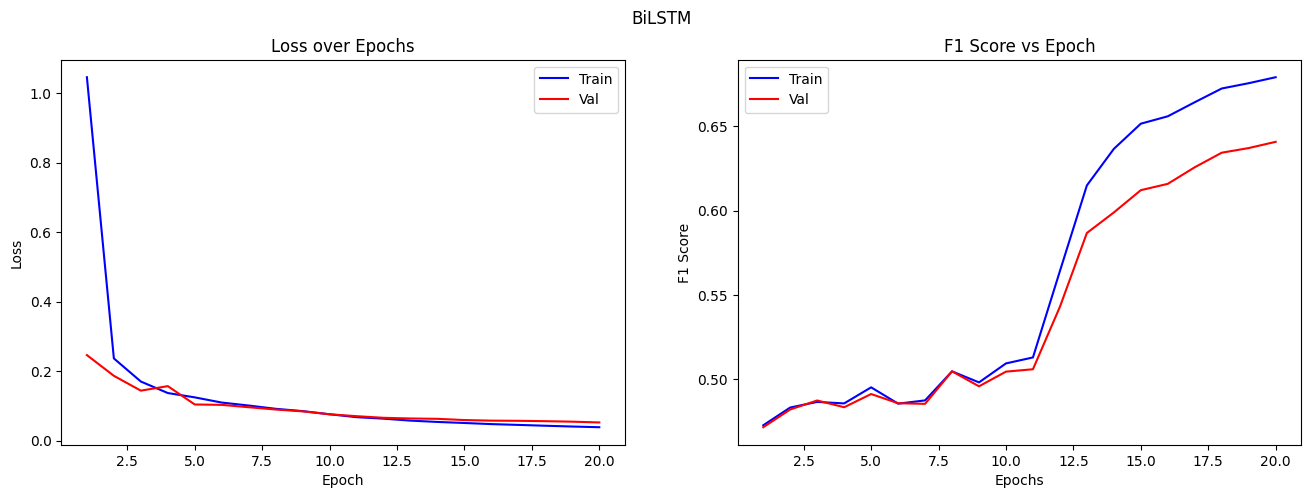

<Figure size 640x480 with 0 Axes>

In [36]:
draw_loss_graph(BiLSTM_training,model_name, BiLSTM_f1_callback.train_f1_scores, BiLSTM_f1_callback.val_f1_scores)
save_model(model.get_weights(),model_name,Embedding_name,Dataset)

In [52]:
# loaded_params = load_model(model_name,Embedding_name,Dataset)
with open("BiLSTM_word2vec_3.pkl","rb") as f:
    loaded_params = pickle.load(f)
model_name="BiLSTM"

n_words=vocab_size
n_tags=Y_train.shape[2]
input = Input(shape=(max_len,))
word_embedding_size = 300

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=max_len)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)
out = crf(model)  # output

model = Model(input, out)
model.set_weights(loaded_params)
adam = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 78)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 78, 300)           721800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 78, 600)           1442400   
_________________________________________________________________
time_distributed_10 (TimeDis (None, 78, 4)             2404      
_________________________________________________________________
crf_11 (CRF)                 (None, 78, 4)             44        
Total params: 2,166,648
Trainable params: 2,166,648
Non-trainable params: 0
_________________________________________________________________


c:\Users\gupta\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
c:\Users\gupta\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [53]:
accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])
Y_pred = model.predict(X_test)
real = get_real(Y_test)
pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in real for label in sublist]
predicted_labels_flat = [label for sublist in pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

328/328 [==============================] - 5s 15ms/step
0.9621638641124819
Test F1 Score: 0.5091974110092223
